## Irfan Kadri
## MMAI 831 AIOS assignment

###Imports

In [1]:
import datetime
import pandas as pd
import numpy as np
import subprocess

from google.colab import data_table
data_table.enable_dataframe_formatter()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
##from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
##from sklearn.linear_model import LogisticRegression
##from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use('seaborn-v0_8')
#plt.style.use('Solarize_Light2')

### Load, Split Data and EDA

In [2]:
# First, we'll read the provided labeled training data
csv_url = '/content/drive/MyDrive/MMAI_831/AIOS/MMM_Store sales.csv'
df = pd.read_csv(csv_url)
df = df.drop(df.columns[0], axis=1)

In [3]:
seed = 42
sales_train_df, sales_test_df = train_test_split(df, test_size=0.25, random_state=seed)
print(f'Length of sales train = {len(sales_train_df)}')
print(f'Length of sales test = {len(sales_test_df)}')
print(f'Split = {len(sales_test_df)/len(df)*100}%')

Length of sales train = 750
Length of sales test = 250
Split = 25.0%


In [ ]:
sales_train_df

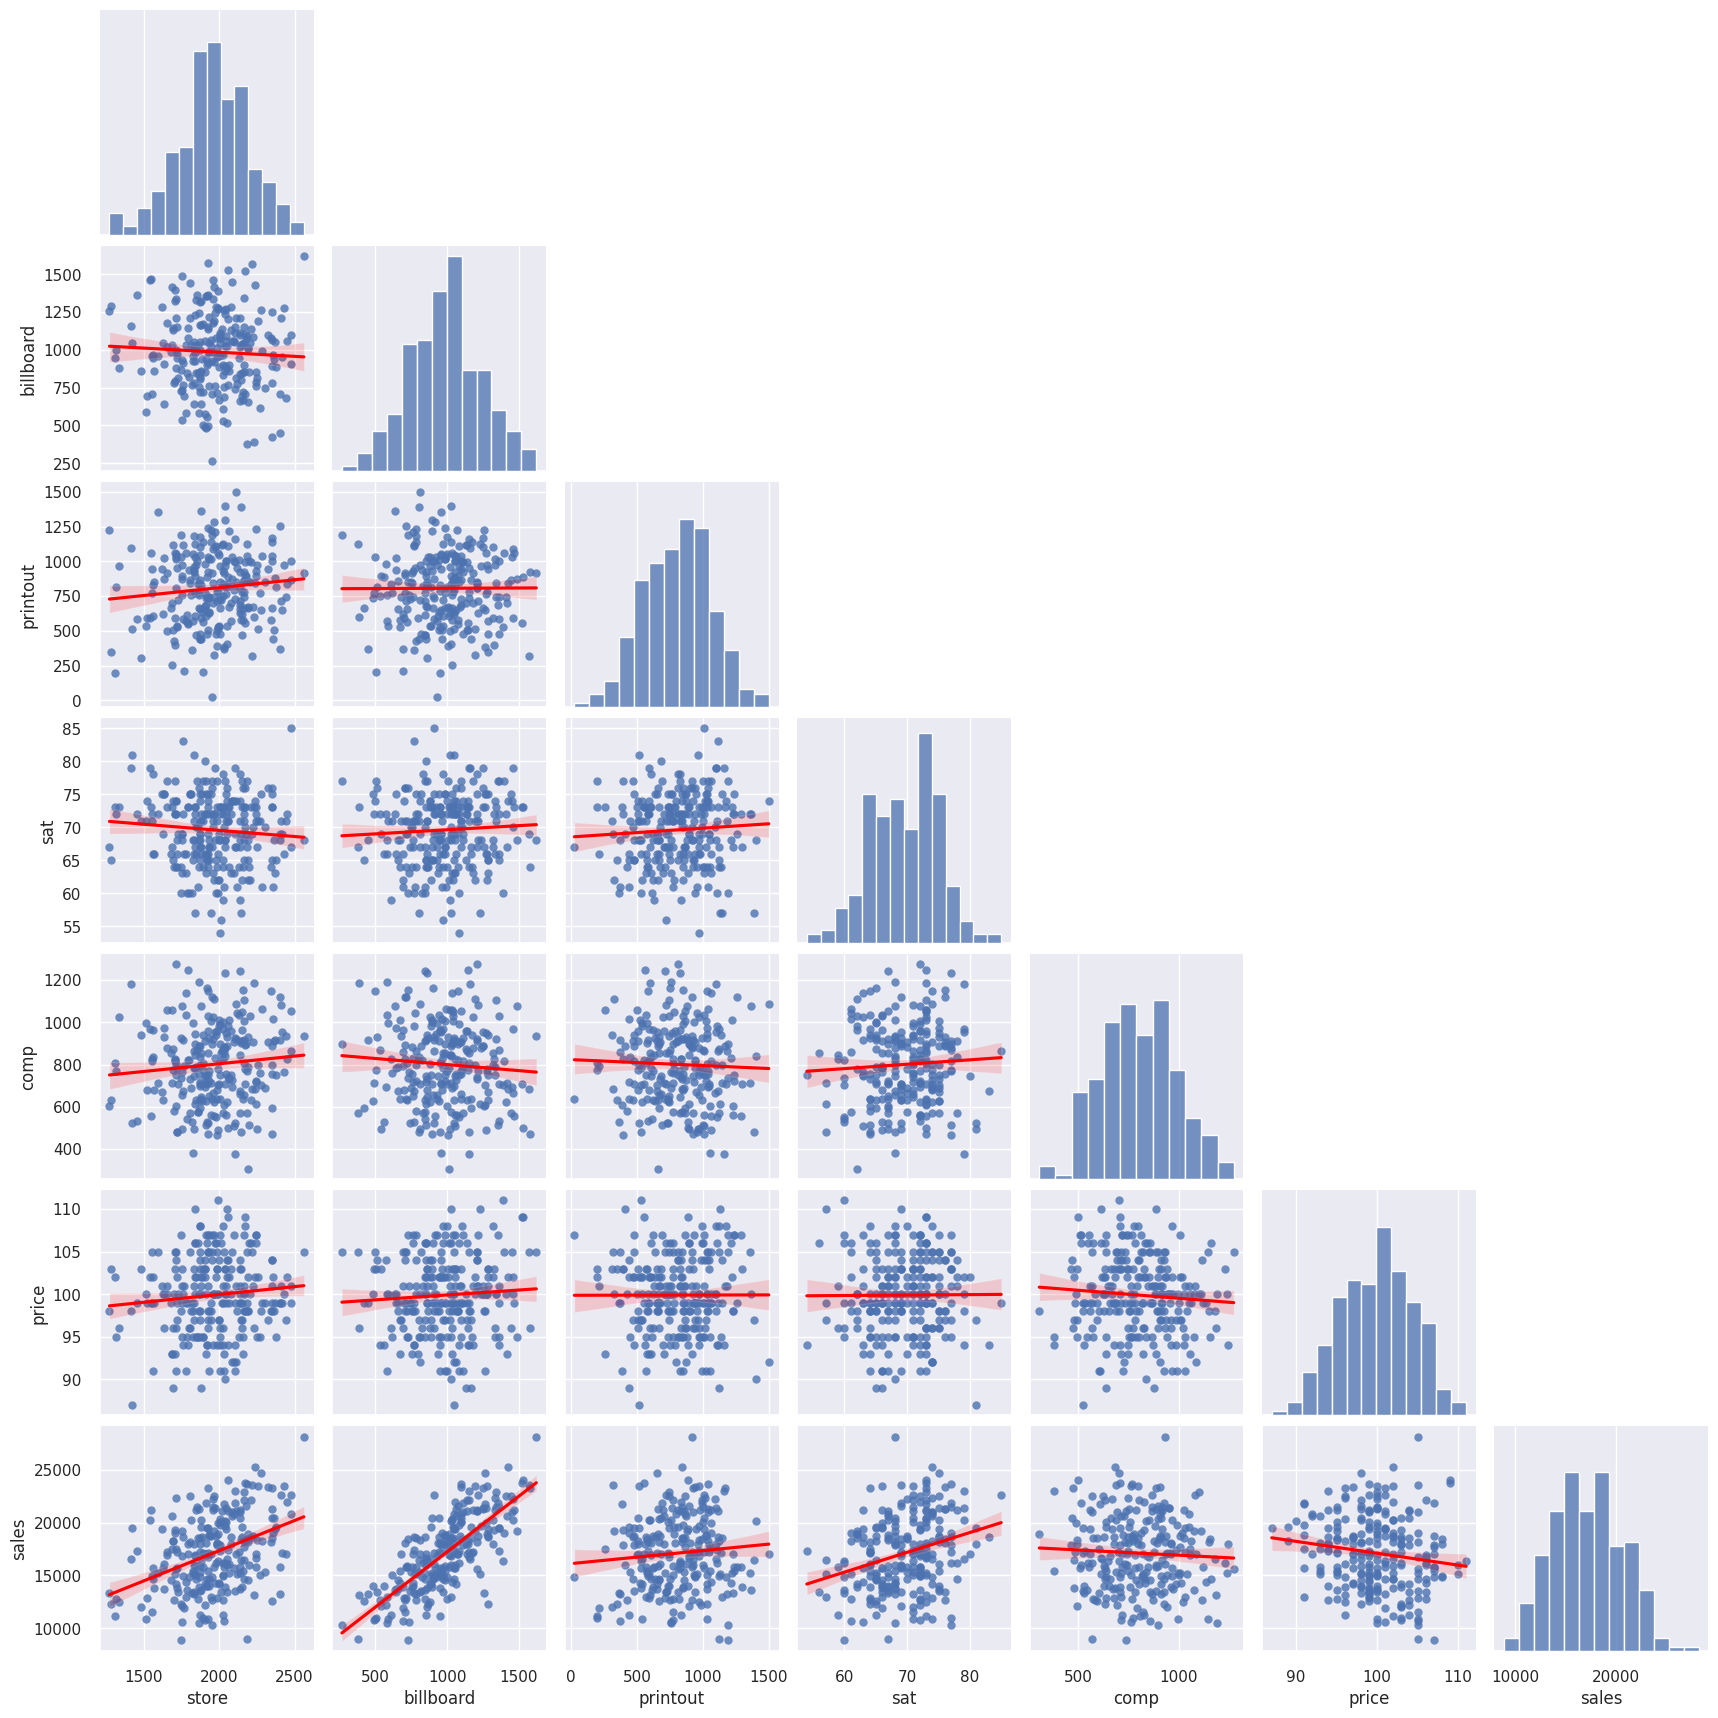

In [5]:
sns.set(rc={'figure.figsize':(2,2)})
sns.pairplot(data=sales_test_df, kind='reg', corner=True, plot_kws={'line_kws':{'color':'red'}})

#### Correlation of the variables

<Axes: >

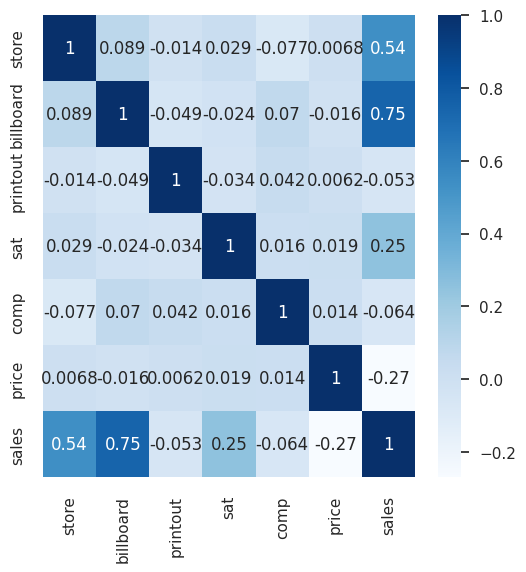

In [6]:
#Lets check if there are any linear correlations between the variables on the data set
correlation_df = sales_train_df.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_df, annot = True, cmap='Blues')

In [7]:
print(sales_test_df.columns)

Index(['store', 'billboard', 'printout', 'sat', 'comp', 'price', 'sales'], dtype='object')


### Helper functions for training, calculating metrics and for plotting the results

In [8]:
# Lets import some ML algorithm modesl
#Import Linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
#Import Tree based Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#Import Clustering 
from sklearn.neighbors import KNeighborsRegressor
#Import XGboost Regressor
from xgboost import XGBRegressor

#Import Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Import Kfold cross validation
from sklearn.model_selection import KFold

In [9]:
#OK lets run some regression - First seperate into X and Y 
X_train = sales_train_df[['store', 'billboard', 'printout', 'sat', 'comp', 'price']]  # independent variables or X
Y_train = sales_train_df['sales']  # dependent variable or Y
X_test = sales_test_df[['store', 'billboard', 'printout', 'sat', 'comp', 'price']]  # independent variables or X
Y_test = sales_test_df['sales']

print(X_train.shape)
print(Y_train.shape)

(750, 6)
(750,)


In [10]:
X_all_df = df[['store', 'billboard', 'printout', 'sat', 'comp', 'price']]  # independent variables or X
Y_all_df = df['sales']  # dependent variable or Y
print(X_all_df.shape)
print(Y_all_df.shape)

(1000, 6)
(1000,)


In [11]:
#With Kfold validation
def fold_fit_and_predict(model, X_all_df, Y_all_df, Y_results_df):
    model_name = type(model).__name__
    n_splits = 3  
    kf = KFold(n_splits=n_splits, shuffle=True)
    
    #Convert to numpy array
    X = X_all_df.values
    Y = Y_all_df.values

    best_fold = None
    best_metric = -float('inf')  # Initialize with a large negative value for metrics like R^2 (higher is better)

    for train_index, test_index in kf.split(X):
        #X_train, X_test, Y_train, Y_test = train_test_split(X[train_index], Y[train_index], test_size=0.25, random_state=42)
        X_train, X_test = X[train_index[:750]], X[test_index[:250]]
        Y_train, Y_test = Y[train_index[:750]], Y[test_index[:250]]
                  
        #Fit on Train data
        model.fit(X_train, Y_train)
        #Do the prediction 
        Y_pred = model.predict(X_test)
        residuals = Y_test - Y_pred
        #coeff = model.coef_
        #y_int = model.intercept_
        
        

        #Calculate MAE
        mae = mean_absolute_error(Y_pred, Y_test)
        #Calculate r2
        r2 = r2_score(Y_test, Y_pred)
        #Mean Squared Error
        mse = mean_squared_error(Y_test, Y_pred)
        #Calculate RMSE
        rmse = np.sqrt(mse)
        
        if r2 > best_metric:
            #best_fold = fold
            bestfold_metric = r2

            #Calculate MAPD
            mean_actual = np.mean(Y_test)
            absolute_deviation = np.abs(Y_pred - Y_test)
            mapd = np.mean(absolute_deviation / mean_actual) * 100
            # Calculate the log-likelihood
            log_like = -0.5 * np.mean(residuals**2)
            # Get the number of parameters
            n_train_samples = len(Y_train)
            n_test_samples = len(Y_test)
            n_features = X_test.shape[1]
            n_params = n_features + 1  # Add 1 for the intercept term
            # Calculate AIC
            aic = -2 * log_like + 2 * n_params
            # Calculate BIC
            bic = -2 * log_like + n_params * np.log(n_test_samples)

            #Wrap all this information into a Data Frame for further plotting or interprettion downstream
            model_results_df = pd.DataFrame({'Model': model_name, 'Actual_Sales': Y_test, 'Predicted_Sales': Y_pred, 
                                            'Residuals': residuals, 'mae[$]': mae, 'r2': r2, 'rmse': rmse, 'MAPD':mapd, 'AIC':aic, 'BIC':bic})
    Y_results_df = pd.concat([Y_results_df, model_results_df], ignore_index=True)

    return Y_results_df

In [12]:
def plot_predict_and_residuals(model, Y_results_df):
    model_name = type(model).__name__
    model_results_df = Y_results_df[Y_results_df['Model'] == model_name]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))
    # Plot the Actual Test data
    sns.scatterplot(data=model_results_df, x='Actual_Sales', y='Predicted_Sales', label= 'Actual vs. Predicted', ax=ax1)
    # Plot the regression line
    sns.lineplot(data=model_results_df, x=Y_test, y=Y_test, color='red', linewidth=2,linestyle='--', label='Ideal',ax=ax1)
    ax1.set_xlabel('Actual Sales')
    ax1.set_ylabel('Predicted Sales')
    ax1.set_title(f'{model_name}: Actual vs Predicted Sales')
    mae = model_results_df['mae[$]'].mean()
    r2 = model_results_df['r2'].mean()
    rmse = model_results_df['rmse'].mean()
    mapd = model_results_df['MAPD'].mean()
    aic = model_results_df['AIC'].mean()
    bic = model_results_df['BIC'].mean()
    ax1.text(0.95, 0.25, f'MAE[$]: {mae:.2f}\n R2: {r2:.2f}\n RMSE: {rmse}\n MAPD: {mapd:.2f}\n AIC: {aic:,.2f}\n BIC: {bic:,.2f}', transform=ax1.transAxes, fontsize=8, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax1.legend()

    #Plot the residuals
    sns.scatterplot(data=model_results_df, x='Predicted_Sales', y='Residuals',ax=ax2)
    ax2.set_ylim(-4000, 4000)
    ax2.axhline(y=0, color='red', linestyle='--')
    ax2.set_xlabel('Predicted Sales')
    ax2.set_ylabel('Residuals')
    ax2.set_title(f'{model_name}: Residual Plot')

    plt.tight_layout()
    plt.show()

### Run Simple Linear Regression

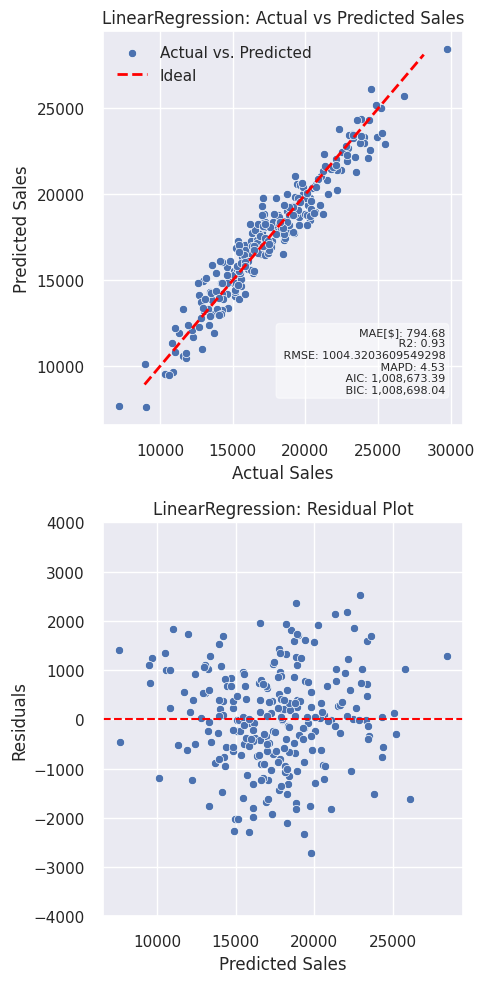

In [13]:
# Lets run a simple linear regression
Y_results_df = pd.DataFrame()
#Linear Regression Model
model = LinearRegression()
Y_results_df = fold_fit_and_predict(model, X_all_df, Y_all_df, Y_results_df)
plot_predict_and_residuals(model, Y_results_df)

In [ ]:
Y_results_df

In [14]:
# Ignore this section I am still working on it
#Lets calculate metrics
model_results_df = pd.DataFrame()
model_name ='LinearRegression'
model_results_df = Y_results_df[Y_results_df['Model'] == model_name]
select_columns = ['Model', 'Actual_Sales', 'Predicted_Sales', 'Residuals']
model_results_df = model_results_df[select_columns]
model_results_df = model_results_df.merge(df, left_on='Actual_Sales', right_on='sales')
model_results_df

selected_columns = ['store', 'billboard','printout', 'sat', 'comp', 'price']
std_error = model_results_df[selected_columns].sem()
print(std_error)

store        14.570669
billboard    15.676841
printout     15.676317
sat           0.312526
comp         12.803125
price         0.305699
dtype: float64


In [ ]:
model_results_df

#### Check for Heteroscedasticity

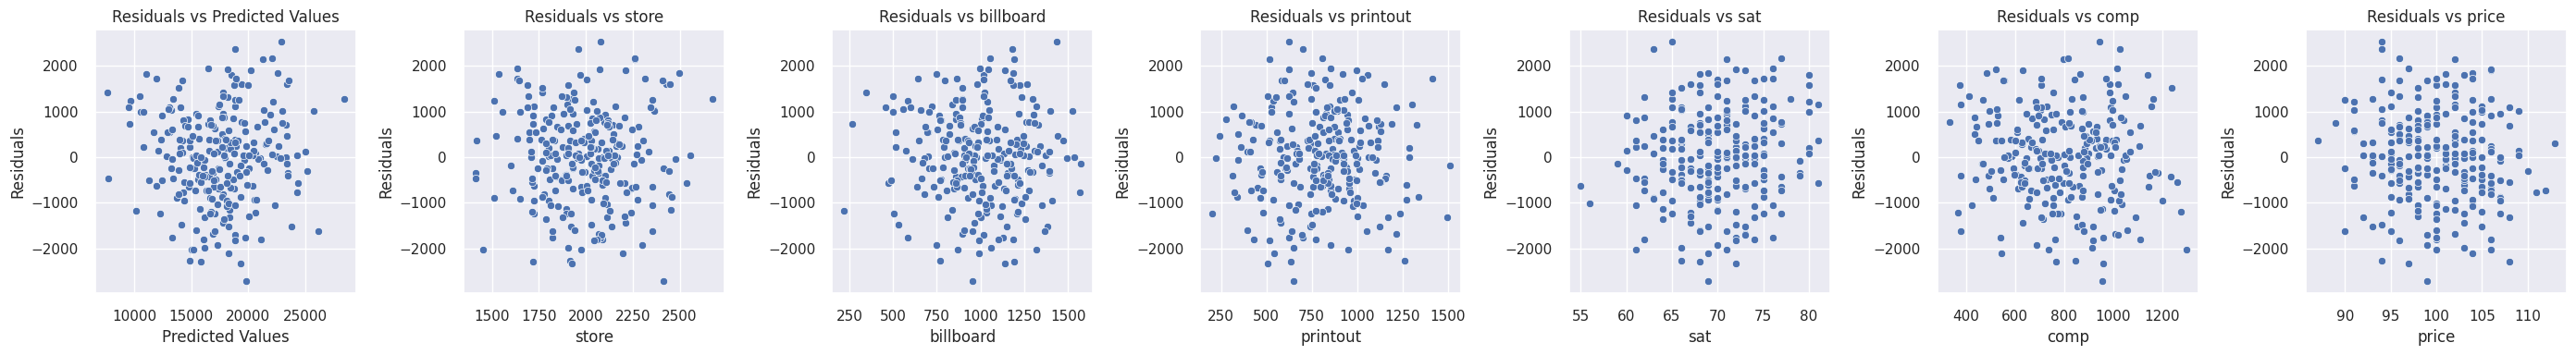

In [15]:
#Lets check for heteroscedasticity
# Plot the residuals against the predicted values
Y_pred = model_results_df['Predicted_Sales']
residuals = model_results_df['Residuals']
selected_columns = ['store', 'billboard','printout', 'sat', 'comp', 'price']
X = model_results_df[selected_columns].values

#plt.figure(figsize=(6, 6))
# Set the figure size
fig, axs = plt.subplots(1, len(selected_columns) + 1, figsize=(28, 4))

# Plot the residuals against the predicted values
sns.scatterplot(x=Y_pred, y=residuals, ax=axs[0])
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Residuals vs Predicted Values')

# Plot the residuals against the independent variables
for i, column in enumerate(selected_columns):
    sns.scatterplot(x=model_results_df[column], y=residuals, ax=axs[i+1])
    axs[i+1].set_xlabel(column)
    axs[i+1].set_ylabel('Residuals')
    axs[i+1].set_title(f'Residuals vs {column}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Run Multiple ML models to select the best one that fits the data

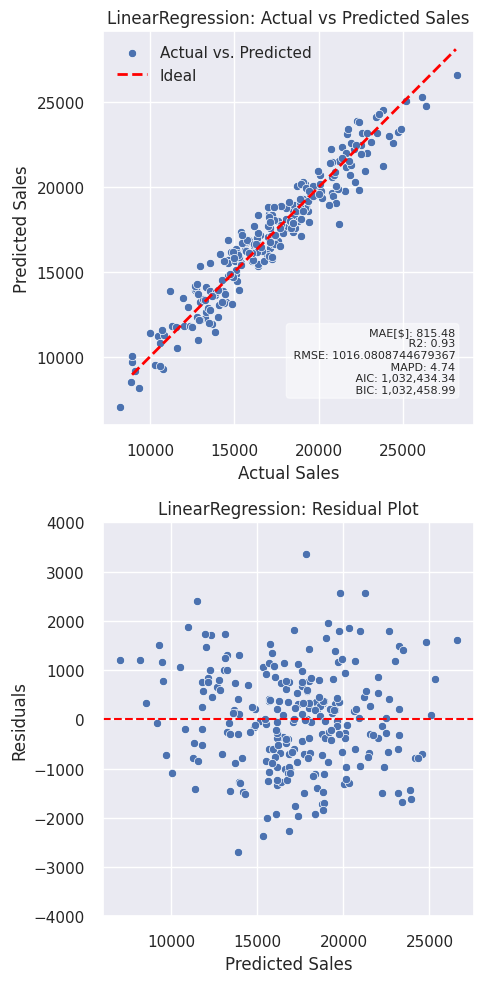

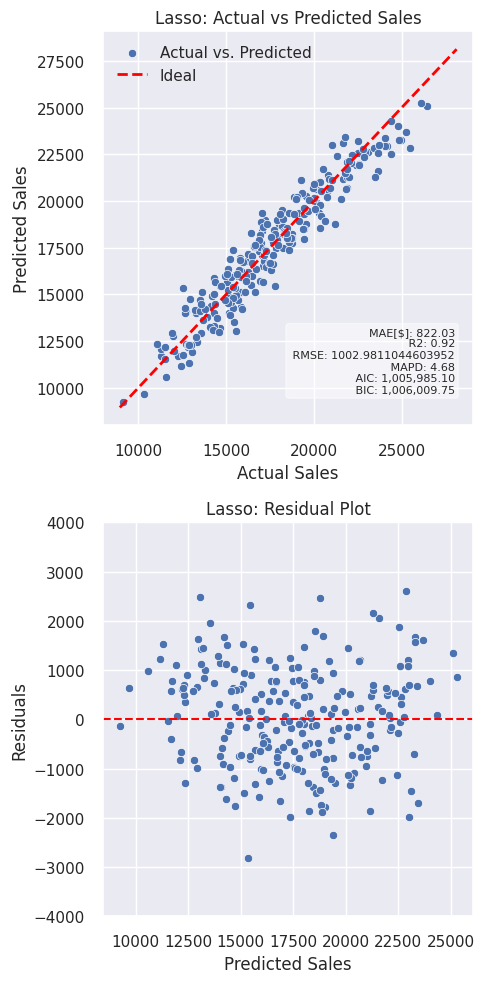

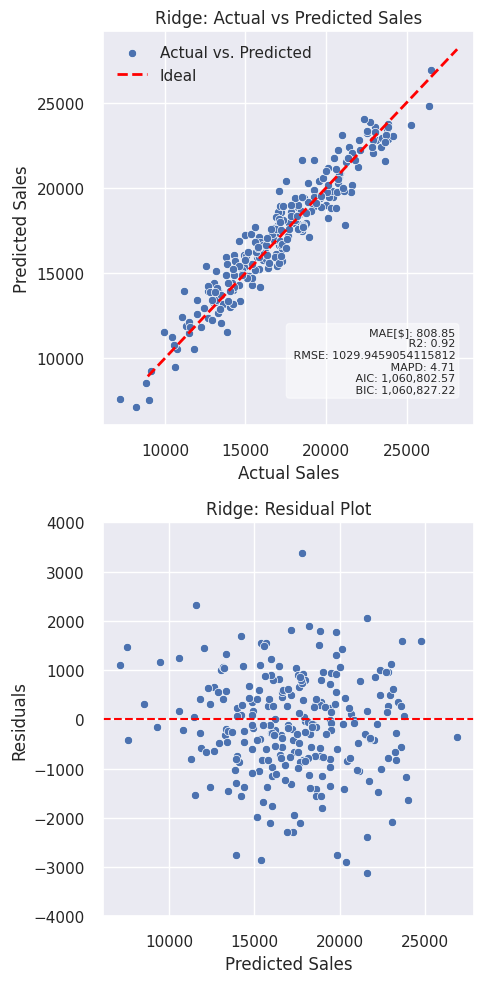

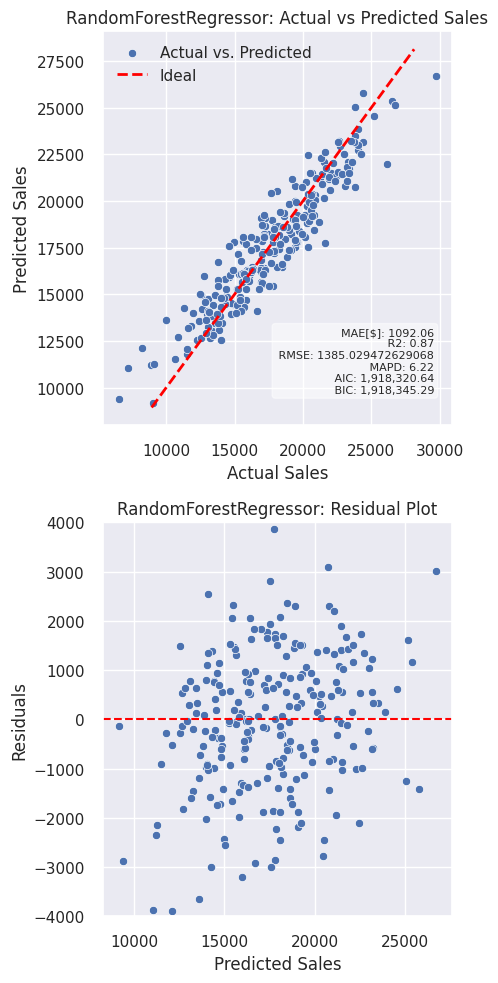

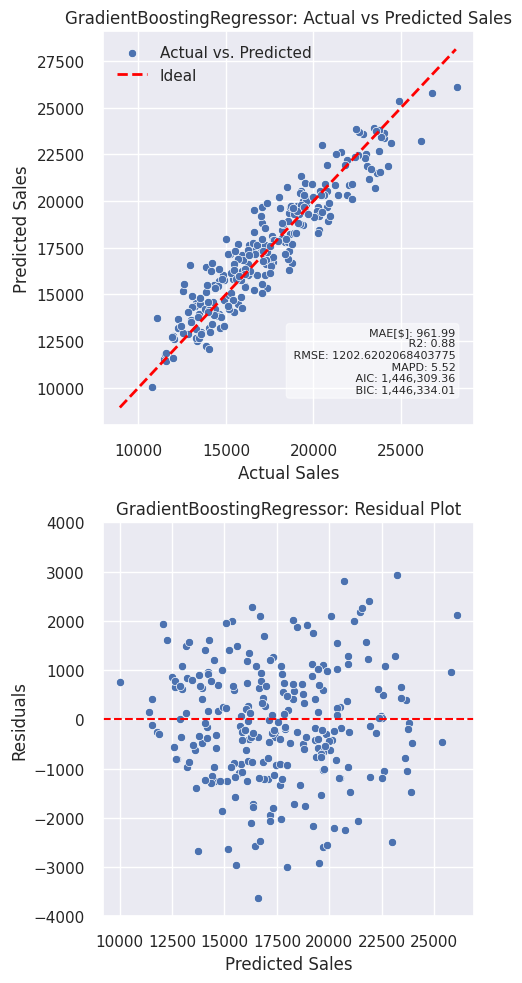

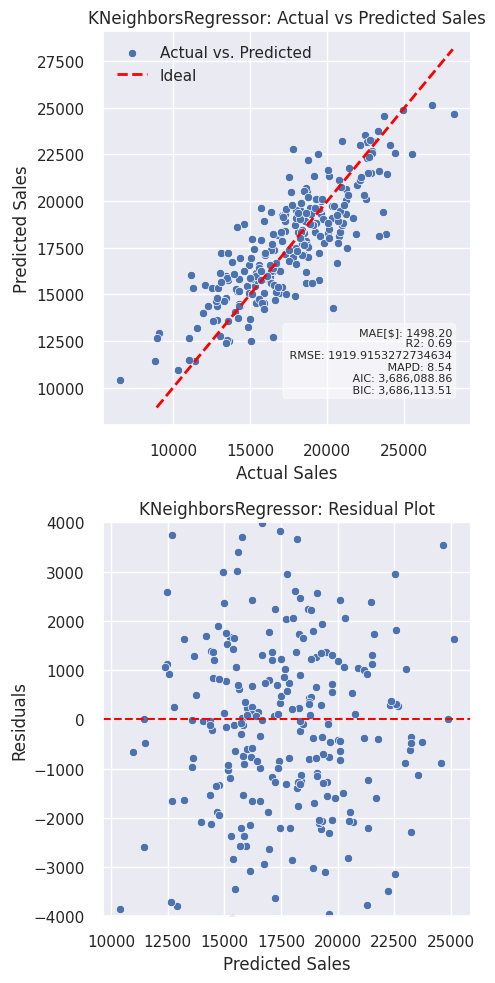

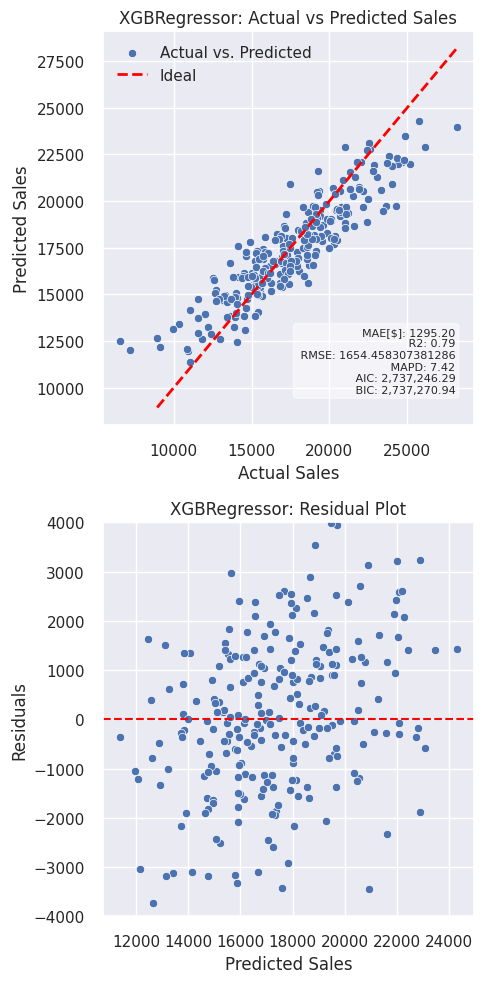

In [16]:
#Lets run many different ML model types to see which one gives us the best performance
Y_results_df = pd.DataFrame()
#Linear Regression Model
model = LinearRegression()
Y_results_df = fold_fit_and_predict(model, X_all_df, Y_all_df, Y_results_df)
plot_predict_and_residuals(model, Y_results_df)
#Lasso Model
model = Lasso()
Y_results_df = fold_fit_and_predict(model, X_all_df, Y_all_df, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#Ridge Regression Model
model = Ridge()
Y_results_df = fold_fit_and_predict(model, X_all_df, Y_all_df, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#Random Forest Regression model
model = RandomForestRegressor()
Y_results_df = fold_fit_and_predict(model, X_all_df, Y_all_df, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#Gradient Boosting Regressor model
model= GradientBoostingRegressor()
Y_results_df = fold_fit_and_predict(model, X_all_df, Y_all_df, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#K-Neighbours Regressor model
model = KNeighborsRegressor()
Y_results_df = fold_fit_and_predict(model, X_all_df, Y_all_df, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#XGBoost
#model = XGBRegressor()
model = XGBRegressor(objective ='reg:squarederror', n_estimators=10000, random_state=42, eta=0.1, learning_rate=0.01, colsample_bytree=0.4, max_depth=10, num_class=1, reg_lambda=1)
Y_results_df = fold_fit_and_predict(model, X_all_df, Y_all_df, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)

In [ ]:
Y_results_df

#### Summary of ML model performance

In [19]:
metrics_df = Y_results_df.groupby('Model').agg({'mae[$]': 'mean', 'r2': 'mean', 'rmse': 'mean', 'MAPD': 'mean', 'AIC': 'mean', 'BIC': 'mean'})
metrics_df = metrics_df.sort_values(by='rmse')
metrics_df

,mae[$],r2,rmse,MAPD,AIC,BIC
Model,,,,,,
Lasso,822.032756,0.916338,1002.981104,4.681327,1.005985e+06,1.006010e+06
LinearRegression,815.476353,0.925098,1016.080874,4.742027,1.032434e+06,1.032459e+06
Ridge,808.847964,0.917861,1029.945905,4.706689,1.060803e+06,1.060827e+06
GradientBoostingRegressor,961.987801,0.875397,1202.620207,5.520037,1.446309e+06,1.446334e+06
RandomForestRegressor,1092.060613,0.870508,1385.029473,6.219046,1.918321e+06,1.918345e+06
XGBRegressor,1295.203817,0.788909,1654.458307,7.418204,2.737246e+06,2.737271e+06
KNeighborsRegressor,1498.201509,0.689643,1919.915327,8.543943,3.686089e+06,3.686114e+06


In [134]:
Y_results_df.columns

Index(['Model', 'Actual_Sales', 'Predicted_Sales', 'Residuals', 'mae[$]', 'r2',
       'rmse', 'MAPD', 'AIC', 'BIC'],
      dtype='object')

In [20]:
#Lets Ensemble the models to see if we get better results
#LR_model_results_df = pd.DataFrame()
#model_name ='LinearRegression'
#LR_model_results_df = Y_results_df[Y_results_df['Model'] == model_name]

#ensemble_models = ['LinearRegression', 'XGBRegressor', 'GradientBoostingRegressor']
ensemble_models = ['Lasso', 'Ridge', 'LinearRegression']
ensemble_Y_results_df = Y_results_df[Y_results_df['Model'].isin(ensemble_models)]
predicted_sales = ensemble_Y_results_df['Predicted_Sales']
actual_sales = ensemble_Y_results_df['Actual_Sales']
rmse_scores = np.sqrt(mean_squared_error(predicted_sales, actual_sales))
print('Ensembled RMSE score:', rmse_scores)
r2_scores = r2_score(actual_sales, predicted_sales)
print('Ensembled R2 score:', r2_scores)

Ensembled RMSE score: 1016.3955934966468
Ensembled R2 score: 0.9201516075830058


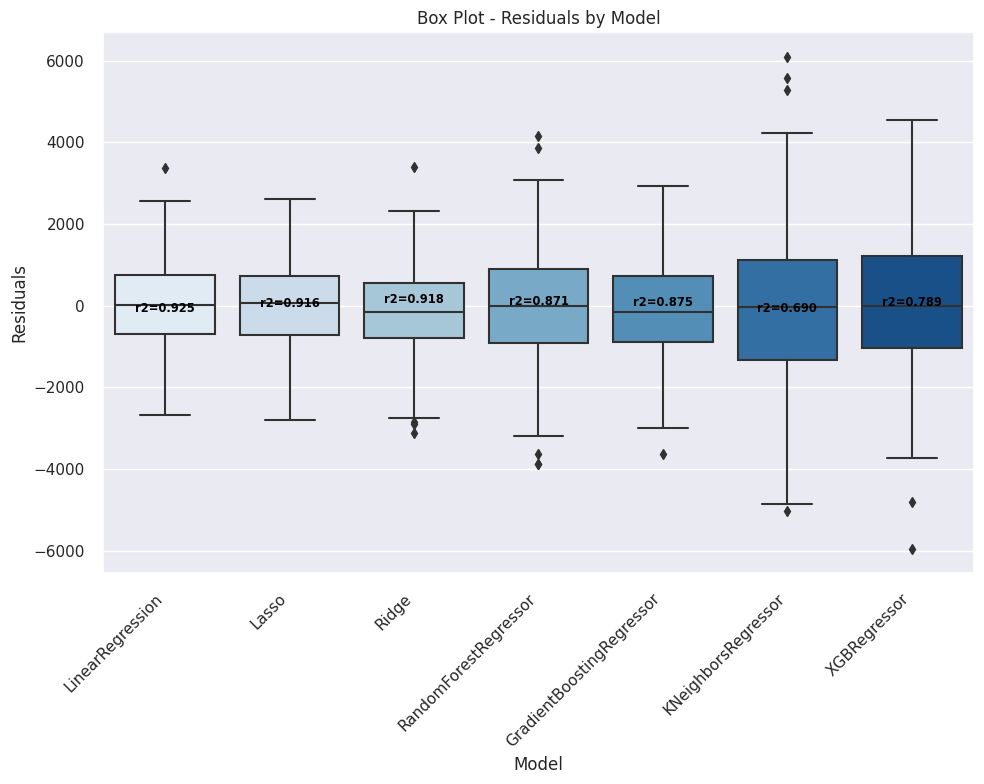

In [21]:
#Lets plot the distribution of the residuals to chose the best model
fig, ax = plt.subplots(figsize=(10, 8))
#sns.boxplot(data=Y_results_df, y='Actual_Sales', ax=ax, palette='Greens')
sns.boxplot(data=Y_results_df, x='Model', y='Residuals', ax=ax, palette='Blues')
ax.set_xlabel('Model')
ax.set_ylabel('Residuals')
ax.set_title('Box Plot - Residuals by Model')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

medians = Y_results_df.groupby('Model')['Residuals'].median()
vertical_offset = Y_results_df['Residuals'].median() * 0.05 # offset from median for display

for xtick, median in zip(ax.get_xticks(), medians):
    r2_score = Y_results_df.loc[Y_results_df['Model'] == ax.get_xticklabels()[xtick].get_text(), 'r2'].mean()
    ax.text(xtick, median + vertical_offset, f"r2={r2_score:.3f}", horizontalalignment='center', size='x-small', color='black', weight='semibold')



plt.tight_layout()
plt.show()

In [110]:
#Lets try a Deep Learning model just to see what happens :)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError


# Initialize an empty list to store the R2 scores for each fold
r2_scores = []

# Perform k-fold cross-validation
folds = 5  # Number of folds for cross-validation
kf = KFold(n_splits=folds)

X = X_all.values
Y = Y_all.values

for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold, Y_train_fold, Y_test_fold = train_test_split(X[train_index], Y[train_index], test_size=0.25, random_state=42)
    #X_train_fold, X_test_fold = X[train_index], X[test_index]
    #Y_train_fold, Y_test_fold = Y[train_index], Y[test_index]
    
    
    

    #Build model
    model = Sequential()
    model.add(Dense(256, activation ='relu', input_shape=(X_train_fold.shape[1],)))
    model.add(Dense(64, activation ='relu'))
    model.add(Dense(1,activation='linear'))

    #Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['RootMeanSquaredError'])
    #Train the model
    model.fit(X_train_fold, Y_train_fold, batch_size=24, epochs=20)
    #Evaluate the model
    loss, rmse = model.evaluate(X_test_fold, Y_test_fold)
    #make predictions
    Y_pred = model.predict(X_test_fold)
    r2 = r2_score(Y_test_fold, Y_pred)
    r2_scores.append(r2)

print('R2_score', r2_scores)

Epoch 1/20
25/25 [==============================] - 1s 4ms/step - loss: 251389488.0000 - root_mean_squared_error: 15855.2666
Epoch 2/20
25/25 [==============================] - 0s 4ms/step - loss: 85317656.0000 - root_mean_squared_error: 9236.7559
Epoch 3/20
25/25 [==============================] - 0s 4ms/step - loss: 10100671.0000 - root_mean_squared_error: 3178.1553
Epoch 4/20
25/25 [==============================] - 0s 5ms/step - loss: 8110871.0000 - root_mean_squared_error: 2847.9590
Epoch 5/20
25/25 [==============================] - 0s 4ms/step - loss: 7635438.0000 - root_mean_squared_error: 2763.2297
Epoch 6/20
25/25 [==============================] - 0s 4ms/step - loss: 7184933.5000 - root_mean_squared_error: 2680.4727
Epoch 7/20
25/25 [==============================] - 0s 4ms/step - loss: 6750208.5000 - root_mean_squared_error: 2598.1165
Epoch 8/20
25/25 [==============================] - 0s 4ms/step - loss: 6345718.0000 - root_mean_squared_error: 2519.0708
Epoch 9/20
25/25 [=

### With no K-Folds - Need to delete this code if we don't need it

In [ ]:
#Without K fold cross validation
def fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df):
    model_name = type(model).__name__    
    #Fit on Train data
    model.fit(X_train, Y_train)
    #Do the prediction 
    Y_pred = model.predict(X_test)
    residuals = Y_test - Y_pred
    #coeff = model.coef_
    #y_int = model.intercept_
    
    #Calculate MAE
    mae = mean_absolute_error(Y_pred, Y_test)
    #Calculate r2
    r2 = r2_score(Y_test, Y_pred)
    #Mean Squared Error
    mse = mean_squared_error(Y_test, Y_pred)
    #Calculate RMSE
    rmse = np.sqrt(mse)
    #Calculate MAPD
    mean_actual = np.mean(Y_test)
    absolute_deviation = np.abs(Y_pred - Y_test)
    mapd = np.mean(absolute_deviation / mean_actual) * 100
    # Calculate the log-likelihood
    log_like = -0.5 * np.mean(residuals**2)
    # Get the number of parameters
    n_train_samples = len(Y_train)
    n_test_samples = len(Y_test)
    n_features = X_test.shape[1]
    n_params = n_features + 1  # Add 1 for the intercept term
    # Calculate AIC
    aic = -2 * log_like + 2 * n_params
    # Calculate BIC
    bic = -2 * log_like + n_params * np.log(n_test_samples)

    #Wrap all this information into a Data Frame for further plotting or interprettion downstream
    model_results_df = pd.DataFrame({'Model': model_name, 'Actual_Sales': Y_test, 'Predicted_Sales': Y_pred, 
                                    'Residuals': residuals, 'mae[$]': mae, 'r2': r2, 'rmse': rmse, 'MAPD':mapd, 'AIC':aic, 'BIC':bic})
    Y_results_df = pd.concat([Y_results_df, model_results_df], ignore_index=True)
    return Y_results_df

In [ ]:
# Lets run a simple linear regression
Y_results_df = pd.DataFrame()
#Linear Regression Model
model = LinearRegression()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model, Y_results_df)

In [ ]:
#Lets run many different ML model types to see which one gives us the best performance
Y_results_df = pd.DataFrame()
#Linear Regression Model
model = LinearRegression()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model, Y_results_df)
#Lasso Model
model = Lasso()
Y_results_df =fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#Ridge Regression Model
model = Ridge()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#Random Forest Regression model
model = RandomForestRegressor()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#Gradient Boosting Regressor model
model= GradientBoostingRegressor()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#K-Neighbours Regressor model
model = KNeighborsRegressor()
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)
#XGBoost
#model = XGBRegressor()
model = XGBRegressor(objective ='reg:squarederror', n_estimators=10000, random_state=42, eta=0.1, learning_rate=0.01, colsample_bytree=0.4, max_depth=10, num_class=1, reg_lambda=1)
Y_results_df = fit_and_predict(model, X_train, Y_train, X_test, Y_test, Y_results_df)
plot_predict_and_residuals(model,Y_results_df)